In [1]:
from ml_mlp import MLP_Model
from ml_mlp import Linear_Model
import resources
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
%matplotlib inline

# Load in feature datasets. Remove wear in phase and combine.

In [3]:
exp5 = resources.load('Test 5')
exp7 = resources.load('Test 7')
exp8 = resources.load('Test 8')
exp9 = resources.load('Test 9')

In [4]:
dfs = [exp5.features.drop([23, 24]), exp7.features, exp8.features, exp9.features]
main_df = pd.concat(dfs)
main_df = main_df.drop(columns=['Runout', 'Form error', 'Peak radius', 'Radius diff']).drop([0, 1, 2, 3])
main_df.reset_index(drop=True, inplace=True)

In [5]:
main_df

,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius
0,2.114221,7.972116,22.575564,-0.037290,46.668332,75.681806,42.884298,0.673830
1,2.231453,7.937418,20.322581,-0.030997,47.223830,76.327769,43.081297,0.672418
2,2.218086,8.176863,21.918605,-0.013387,47.121927,76.566675,42.880229,0.672192
3,2.288784,7.950098,19.731200,-0.023563,47.644655,76.725483,43.181153,0.672081
4,2.297028,8.107973,22.351243,-0.014962,47.152297,76.585970,43.056571,0.671812
...,...,...,...,...,...,...,...,...
687,1.889985,12.288077,26.251820,-0.030479,56.359652,74.975288,49.552041,0.637869
688,1.898108,10.854337,26.748223,0.007456,58.788428,74.157487,49.662471,0.635268
689,1.136728,9.676960,16.286327,0.003635,61.444954,66.377575,49.861184,0.614853
690,1.091805,13.786838,17.095652,0.011310,64.836350,65.260283,49.576784,0.611372


# Create MLP class.

In [6]:
mlp_reg = MLP_Model(feature_df=main_df,
                    target='Mean radius',
                    tb=True,
                    tb_logdir='tb/MLP/logdir_test/',
                    params={'loss': 'mae',
                            'no_layers': 2,
                            'no_nodes': 128,
                            'epochs': 200,
                                }
                   )

# Score MLP model

CV Model:   0%|          | 0/10 [00:00<?, ?it/s]

-----------------------------------------------------------------
CV Training Scores:
-----------------------------------------------------------------
MAE: 2.909 (± 1.406) µm
MSE: 21.593 (± 18.029) µm²
R^2: 0.833 (± 0.115)
-----------------------------------------------------------------


Training:   0%|                                                                               0/200 ETA: ?s,  …

-----------------------------------------------------------------
Model Validation Scores:
-----------------------------------------------------------------
MAE = 3.240 um
MSE = 27.602 um^2
R^2 = 0.791
-----------------------------------------------------------------


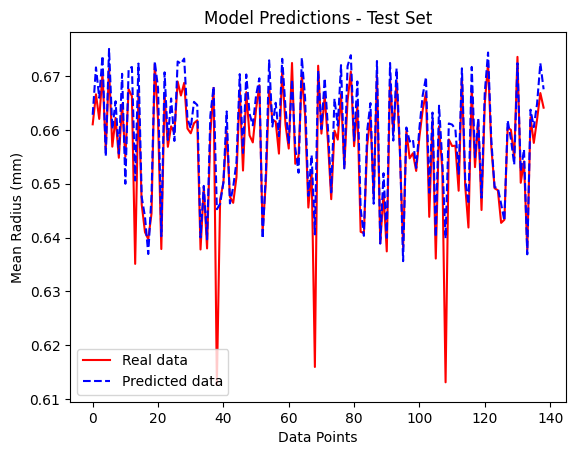

In [7]:
mlp_reg.cv(n_splits=10)
mlp_reg.fit(validation_split=0.1, verbose=0)
mlp_reg.score(plot_fig=True);

# Show plot of Predictions vs Actual

Predict unseen data with model

In [8]:
y = mlp_reg.val_data[1].values
y_pred = mlp_reg.model.predict(mlp_reg.val_data[0].values, verbose=0)

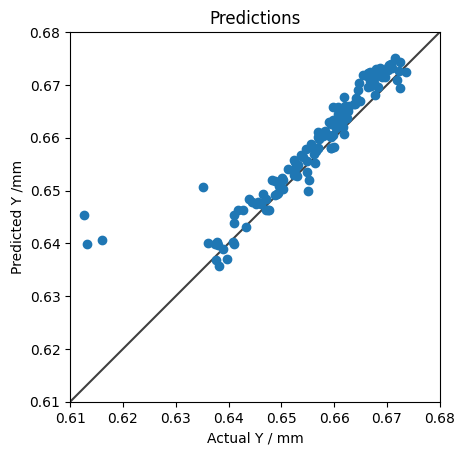

In [9]:
fig, ax = plt.subplots()
# ax.grid()
ax.scatter(y,y_pred)
ax.plot()
ax.set_xlim([0.61,0.68])
ax.set_ylim([0.61,0.68])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
plt.xlabel('Actual Y / mm')
plt.ylabel('Predicted Y /mm')
plt.title('Predictions');

# Histogram of prediction errors

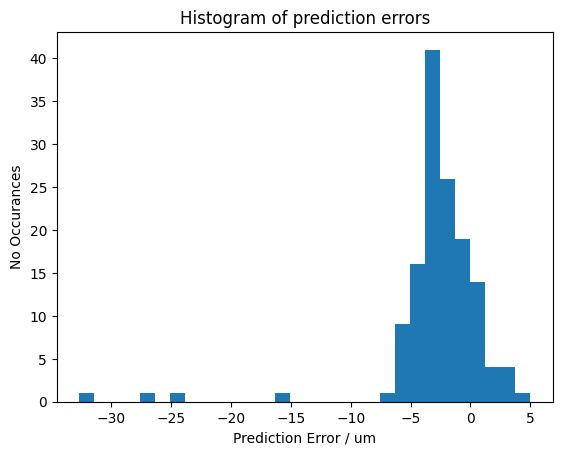

In [10]:
diff = (y - y_pred)*1000

fig, ax = plt.subplots()
ax.hist(diff, bins=30)
plt.xlabel('Prediction Error / um')
plt.ylabel('No Occurances')
plt.title('Histogram of prediction errors');

# Create Linear Model

In [11]:
lin_reg = Linear_Model(feature_df=main_df, target='Mean radius')
lin_reg.fit()
lin_reg.score(plot_fig=False);

-----------------------------------------------------------------
Model Validation Scores:
-----------------------------------------------------------------
MAE = 5.317 um
MSE = 62.556 um^2
R^2 = 0.420
-----------------------------------------------------------------
